In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [50]:
df = pd.read_csv("../data/processed/dataset_cleaned.csv")  # after preprocessing


In [51]:
df.head()

,Timestamp,Source_IP,Destination_IP,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,Scan_Type
0,2025-06-06 06:04:08,192.168.54.167,220.159.139.17,167,SSH,ICMP,2954.0,Mozilla/5.0,Success,0,Normal
1,2025-06-04 15:20:59,192.168.193.254,201.83.205.167,80,FTP,UDP,206.0,Wget/1.20.3,Success,0,Normal
2,2025-06-03 07:23:49,192.168.91.17,211.0.177.164,21,SSH,ICMP,977.0,nmap/7.80,Success,0,Normal
3,2025-06-03 11:35:42,192.168.108.75,187.49.21.67,22,HTTP,TCP,521.0,curl/7.68.0,Success,0,Normal
4,2025-06-05 06:09:02,192.168.245.254,189.62.16.12,53,Telnet,TCP,251.0,Wget/1.20.3,Success,0,Normal


In [ ]:
df['Intrusion'].value_counts()


Intrusion
0    8000
1     866
Name: count, dtype: int64

In [53]:
# Converting TimeStamp to Useful features

df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Day'] = df['Timestamp'].dt.day
df['Weekday'] = df['Timestamp'].dt.weekday



In [54]:
# Dropping raw timestamp
df.drop(columns=['Timestamp'], inplace=True)


In [55]:
# Converting IPs to Integers

import hashlib

def hash_ip(ip):
    return int(hashlib.md5(ip.encode()).hexdigest(), 16) % (10**8)

df['Source_IP'] = df['Source_IP'].apply(hash_ip)
df['Destination_IP'] = df['Destination_IP'].apply(hash_ip)


In [56]:
df = pd.get_dummies(df, columns=["Request_Type", "Protocol", "User_Agent", "Status", "Scan_Type"], drop_first=True)


In [57]:
# Checking Numerical Endoded Columns

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8866 entries, 0 to 8865
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Source_IP                          8866 non-null   int64  
 1   Destination_IP                     8866 non-null   int64  
 2   Port                               8866 non-null   int64  
 3   Payload_Size                       8866 non-null   float64
 4   Intrusion                          8866 non-null   int64  
 5   Hour                               8866 non-null   int32  
 6   Minute                             8866 non-null   int32  
 7   Day                                8866 non-null   int32  
 8   Weekday                            8866 non-null   int32  
 9   Request_Type_FTP                   8866 non-null   bool   
 10  Request_Type_HTTP                  8866 non-null   bool   
 11  Request_Type_HTTPS                 8866 non-null   bool 

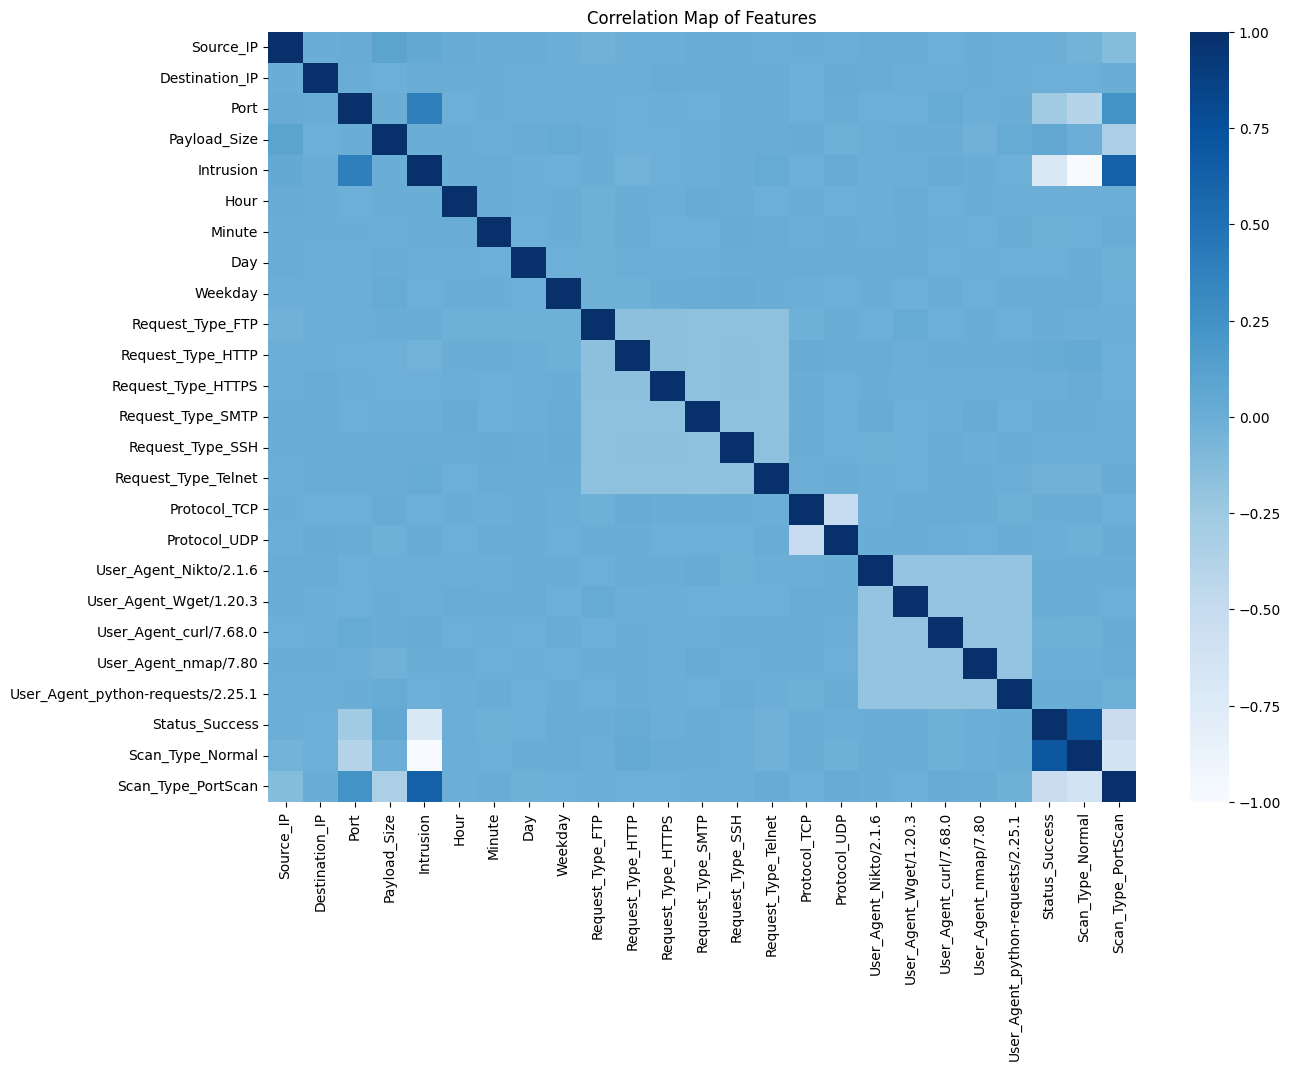

In [58]:
# Correlation Heatmap

plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=False, cmap="Blues")
plt.title("Correlation Map of Features")
plt.show()



In [67]:
df.to_csv("../data/processed/dataset_selection.csv", index=False)


In [59]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
# Used a method of Random Forest for Feature Selection

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Intrusion'])
y = df['Intrusion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances


Scan_Type_Normal                     0.465287
Status_Success                       0.194295
Payload_Size                         0.124467
Scan_Type_PortScan                   0.084621
Port                                 0.081376
Source_IP                            0.020455
Destination_IP                       0.006902
Minute                               0.004950
Hour                                 0.004907
Day                                  0.002036
Weekday                              0.001991
User_Agent_curl/7.68.0               0.000938
Protocol_TCP                         0.000921
Protocol_UDP                         0.000868
Request_Type_HTTP                    0.000744
Request_Type_SMTP                    0.000656
Request_Type_FTP                     0.000651
Request_Type_HTTPS                   0.000645
Request_Type_Telnet                  0.000593
User_Agent_Nikto/2.1.6               0.000580
Request_Type_SSH                     0.000569
User_Agent_python-requests/2.25.1 

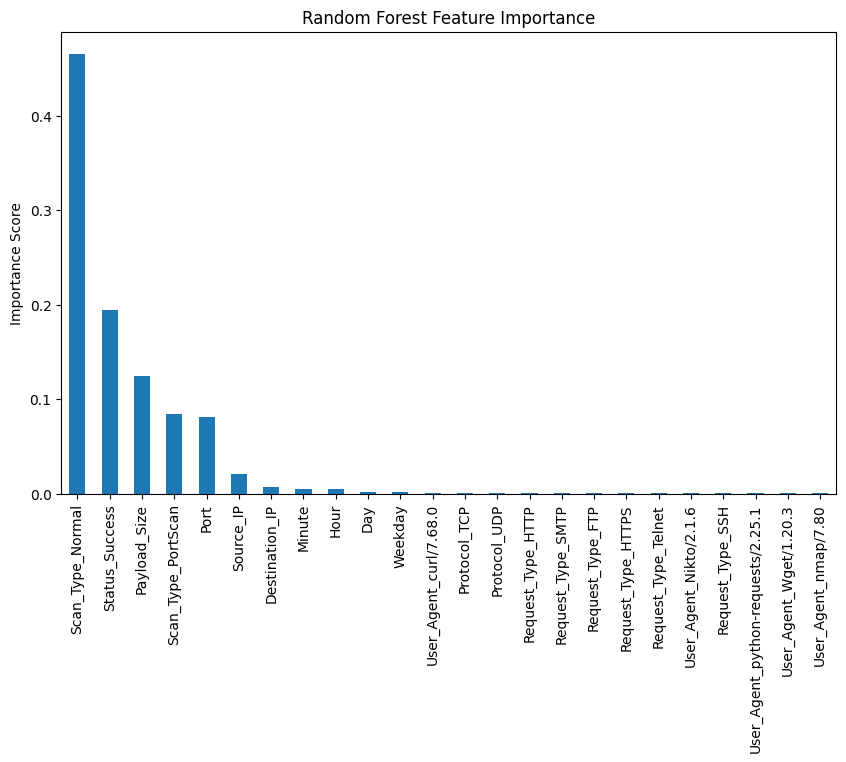

In [61]:
plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title("Random Forest Feature Importance")
plt.ylabel("Importance Score")
plt.show()


In [62]:
# Mutual Information Score

from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
mi_scores


Scan_Type_Normal                     0.321527
Source_IP                            0.300644
Port                                 0.194207
Payload_Size                         0.179797
Status_Success                       0.165385
Scan_Type_PortScan                   0.098405
Weekday                              0.007790
Destination_IP                       0.005097
Request_Type_SSH                     0.002848
User_Agent_nmap/7.80                 0.002528
Request_Type_HTTPS                   0.002490
Protocol_TCP                         0.002403
User_Agent_curl/7.68.0               0.001450
User_Agent_Nikto/2.1.6               0.001319
User_Agent_python-requests/2.25.1    0.001279
Request_Type_SMTP                    0.001172
Request_Type_Telnet                  0.000324
Day                                  0.000000
Hour                                 0.000000
Minute                               0.000000
Protocol_UDP                         0.000000
Request_Type_FTP                  

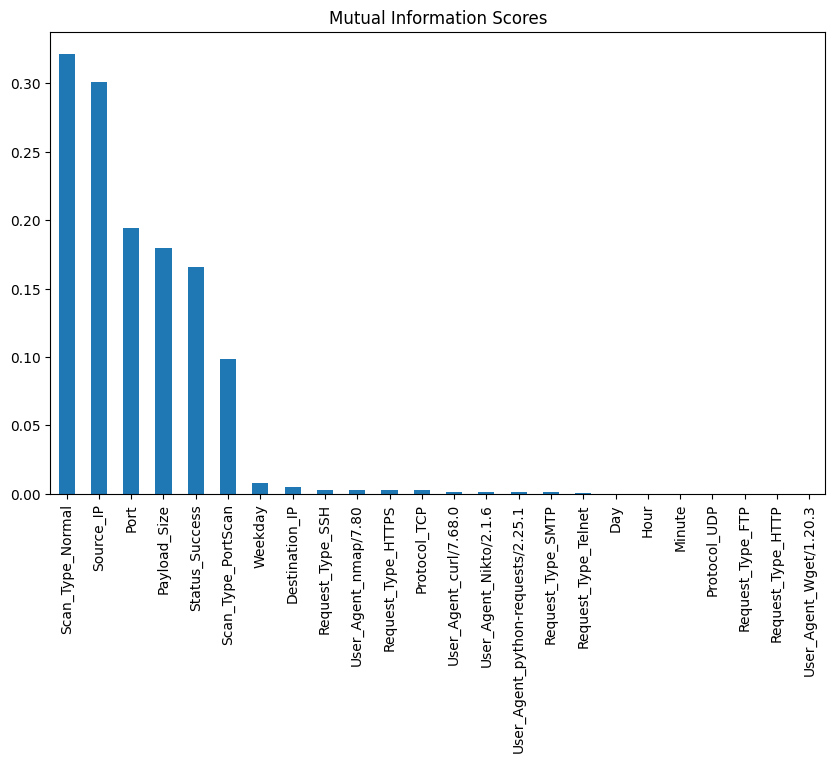

In [63]:
plt.figure(figsize=(10, 6))
mi_scores.plot(kind='bar')
plt.title("Mutual Information Scores")
plt.show()


In [64]:
# Chi-Square Test (for categorical + numerical)

from sklearn.feature_selection import chi2

chi_scores = chi2(X.abs(), y)
chi_series = pd.Series(chi_scores[0], index=X.columns).sort_values(ascending=False)
chi_series


Source_IP                            2.648211e+08
Destination_IP                       2.376715e+07
Port                                 6.493404e+04
Scan_Type_PortScan                   3.251732e+03
Scan_Type_Normal                     8.660000e+02
Status_Success                       5.688860e+02
Payload_Size                         1.446559e+02
Minute                               1.440961e+01
Request_Type_HTTP                    8.442360e+00
Request_Type_Telnet                  4.738406e+00
User_Agent_curl/7.68.0               3.036107e+00
Weekday                              2.768026e+00
Protocol_UDP                         2.031003e+00
Request_Type_HTTPS                   9.434137e-01
Hour                                 9.207601e-01
User_Agent_python-requests/2.25.1    5.772712e-01
Protocol_TCP                         5.749260e-01
User_Agent_nmap/7.80                 3.585741e-01
User_Agent_Wget/1.20.3               2.210330e-01
Request_Type_SMTP                    2.101897e-01


In [65]:
selected_features = importances.head(10).index.tolist()
selected_features


['Scan_Type_Normal',
 'Status_Success',
 'Payload_Size',
 'Scan_Type_PortScan',
 'Port',
 'Source_IP',
 'Destination_IP',
 'Minute',
 'Hour',
 'Day']

In [66]:
X_selected = df[selected_features]


In [48]:
df[selected_features].head()

,Scan_Type_Normal,Status_Success,Payload_Size,Scan_Type_PortScan,Port,Source_IP,Destination_IP,Minute,Hour,Day
0,True,True,2954.0,False,167,23662783,83989990,4,6,6
1,True,True,206.0,False,80,68429848,38936310,20,15,4
2,True,True,977.0,False,21,34256933,9068034,23,7,3
3,True,True,521.0,False,22,38582138,47389783,35,11,3
4,True,True,251.0,False,53,90073913,63106198,9,6,5
